# 라이브러리 준비

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# 데이터 준비

In [3]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(sub_data_path)

/home/aiffel/aiffel/kaggle_kakr_housing/data/train.csv
/home/aiffel/aiffel/kaggle_kakr_housing/data/test.csv


In [4]:
date_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir,'train.csv')
test_data_path = join(date_dir,'test.csv')

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


# 데이터 전처리

- 이상치 제거

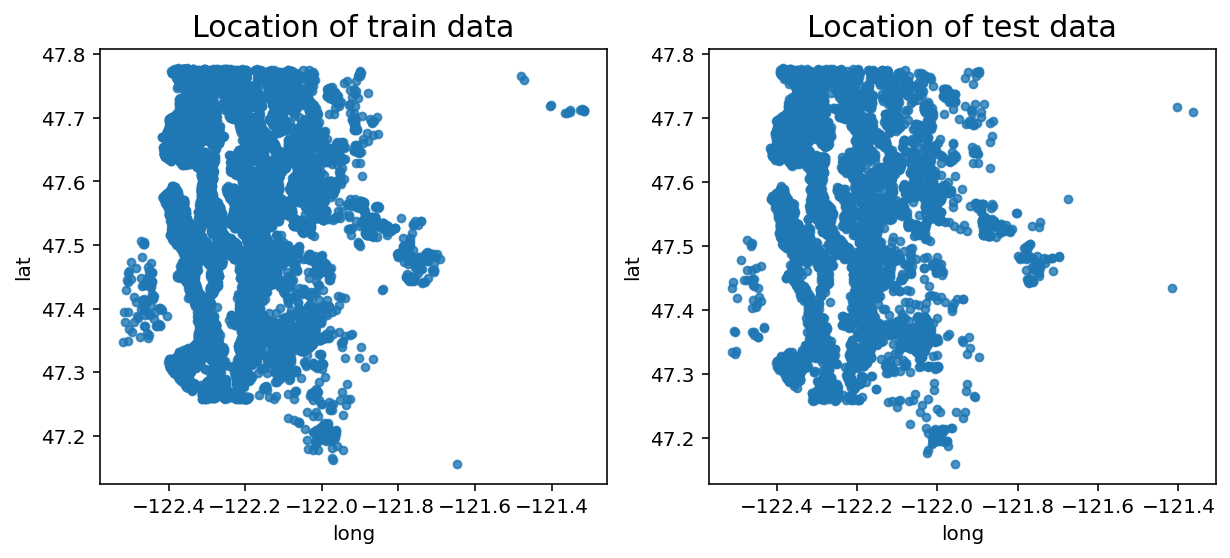

In [5]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))

sns.regplot(data=train, x='long', y='lat',
           fit_reg=False,
           scatter_kws={'s': 15},
           ax=axes[0])
axes[0].grid(False)
axes[0].set_title('Location of train data', fontsize=15)

sns.regplot(data=test, x='long', y='lat',
           fit_reg=False,
           scatter_kws={'s': 15},
           ax=axes[1])
axes[1].grid(False)
axes[1].set_title('Location of test data', fontsize=15)

plt.show()

In [6]:
train[(train['long'] > -121.8) & (train['lat'] < 47.2)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2354,2354,20140624T000000,380000.0,3,2.25,1860,15559,2.0,0,0,...,7,1860,0,1963,0,98022,47.1559,-121.646,1110,11586


In [7]:
test[(test['long'] > -121.6) & (test['lat'] < 47.5)]

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
1378,16413,20140521T000000,3,2.75,2100,10362,2.0,0,0,3,9,1510,590,1998,0,98045,47.4347,-121.417,2240,11842


In [8]:
train.drop([2354])

test.drop([1378])

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,21498,20140626T000000,3,1.75,1500,11968,1.0,0,0,3,6,1500,0,2014,0,98010,47.3095,-122.002,1320,11303
6464,21499,20150126T000000,3,2.00,1490,1126,3.0,0,0,3,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230
6465,21500,20150219T000000,3,2.50,1310,1294,2.0,0,0,3,8,1180,130,2008,0,98116,47.5773,-122.409,1330,1265
6466,21501,20140623T000000,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007


In [9]:
#train data 전처리
# 'date'항목 정리 
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)

#'price' 항목 삭제
y = train['price']
del train['price']

# 'id' 항목 삭제
del train['id']

# y 값 정규화
y = np.log1p(y)

In [10]:
# test data 전처리
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

- 정규화

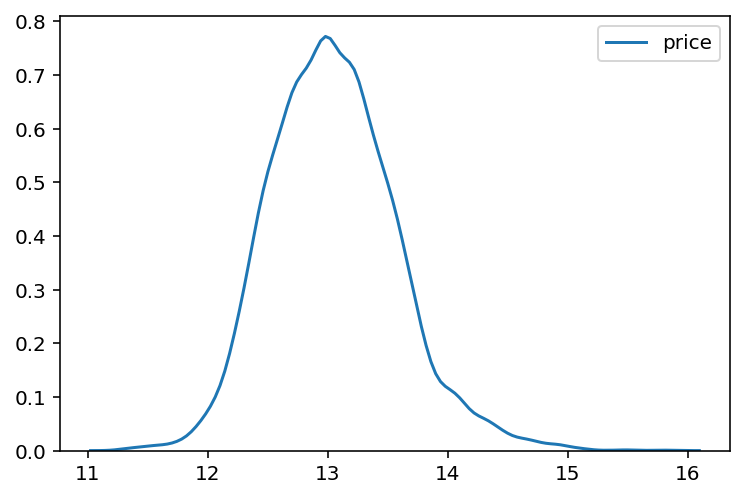

In [11]:
sns.kdeplot(y)
plt.show()

# 모델 정하기

In [12]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [13]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [14]:
def get_scores(models, train, y):
    df = {}

    for model in models:
        model_name = model.__class__.__name__

        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df
get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,128360.196497
RandomForestRegressor,125487.071025
LGBMRegressor,111920.367359
XGBRegressor,110318.637918


# 모델 학습 with GridSearch

In [15]:
param_grid = {
    'n_estimators': [100, 200, 400],
    'max_depth': [10,20,50],
}

In [16]:
"""
다음과 같은 과정을 진행할 수 있는 `my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)` 함수를 구현해 보세요.

1. GridSearchCV 모델로 `model`을 초기화합니다.
2. 모델을 fitting 합니다.
3. params, score에 각 조합에 대한 결과를 저장합니다. 
4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환합니다.
"""
random_state=2020

def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)

    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [17]:

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done  45 out of  45 | elapsed:    4.1s finished


,max_depth,n_estimators,score,RMSLE
2,10,400,-0.026121,0.161619
1,10,200,-0.026188,0.161828
5,20,400,-0.026206,0.161883
8,50,400,-0.026206,0.161883
4,20,200,-0.026245,0.162003
7,50,200,-0.026245,0.162003
0,10,100,-0.027027,0.164399
3,20,100,-0.027051,0.164472
6,50,100,-0.027051,0.164472


In [18]:
model = LGBMRegressor(max_depth=10, n_estimators=400,learning_rate=0.1, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.17611686, 13.08100957, 14.08847854, ..., 13.0521462 ,
       12.71213178, 12.99820275])

# 데이터 저장하기

In [19]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [20]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.161')

/home/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.161.csv saved!


- 많은 feature 때문인지 하이퍼파라미터 값을 바꿔가면서 측정해봐도 rmsle값을 크게 줄이지 못했다.  
- 데이터 전처리 과정에 이상치를 train, test 데이터셋에서 각각 하나씩 삭제했더니 score가 크게 올랐다!   
- score=110645


# 모델학습 with Randomsearch

In [21]:
random_state=2020

def my_RandomSearch(model, train, y, param_grid2, verbose=2, n_jobs=6):
    # GridSearchCV 모델로 초기화
    random_model = RandomizedSearchCV(model,param_distributions=param_grid2, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)

    # 모델 fitting
    random_model.fit(train, y)

    # 결과값 저장
    params = random_model.cv_results_['params']
    score = random_model.cv_results_['mean_test_score']

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

print("슝=3")

슝=3


In [22]:
# gridsearch할때의 파라미터 참고
param_grid2 = {'n_estimators': [int(x) for x in range(0, 501, 100)],
              'max_depth': [int(x) for x in range(10, 100, 10)],
              'learning_rate': [0.1],
              'boosting': ['rf', 'gbdt', 'dart', 'goss'],
                      'num_iterations' : [1000]}

model = LGBMRegressor(random_state=random_state)
my_RandomSearch(model, train, y, param_grid2, verbose=2, n_jobs=6)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:   36.2s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:   49.9s finished


,num_iterations,n_estimators,max_depth,learning_rate,boosting,score,RMSLE
7,1000,100,60,0.1,gbdt,-2.676658e-02,1.636049e-01
9,1000,200,30,0.1,gbdt,-2.676658e-02,1.636049e-01
0,1000,200,30,0.1,dart,-3.254960e-02,1.804151e-01
5,1000,400,40,0.1,dart,-3.254960e-02,1.804151e-01
6,1000,500,30,0.1,dart,-3.254960e-02,1.804151e-01
1,1000,400,10,0.1,goss,-5.280772e+12,2.297993e+06
2,1000,100,40,0.1,goss,-5.294601e+68,2.301000e+34
3,1000,300,80,0.1,goss,-5.294601e+68,2.301000e+34
4,1000,300,90,0.1,goss,-5.294601e+68,2.301000e+34
8,1000,400,50,0.1,rf,NaN,NaN


In [23]:
# 113112점  
save_submission(model, train, y, test, 'lgbm', rmsle='0.163')

/home/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.163.csv saved!


# XGBoost 모델 사용   
- LightGBM으로 일정이상 안떨어져 XGBoost 사용 

In [24]:
# XGBRegressor 모델 사용
# gridsearch할때의 파라미터 참고
param_grid2 = {'n_estimators': [int(x) for x in range(0, 501, 100)],
              'max_depth': [int(x) for x in range(10, 100, 10)],
              'eta': [0.1],
              'booster': ['gblinear', 'gbtree', 'dart'],
                      'nrounds' : [1000]}

model = XGBRegressor(random_state=random_state)
my_RandomSearch(model, train, y, param_grid2, verbose=2, n_jobs=6)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:  3.4min finished


[15:00:33] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1593723605503/work/src/learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




,nrounds,n_estimators,max_depth,eta,booster,score,RMSLE
5,1000,200,10,0.1,dart,-0.027014,0.164361
3,1000,200,30,0.1,dart,-0.028467,0.168723
0,1000,300,80,0.1,gbtree,-0.028495,0.168806
9,1000,100,40,0.1,gbtree,-0.028513,0.168859
8,1000,400,60,0.1,dart,-0.028518,0.168873
1,1000,500,20,0.1,gbtree,-0.028529,0.168904
2,1000,400,20,0.1,gbtree,-0.028529,0.168904
6,1000,400,70,0.1,gblinear,-0.116653,0.341545
7,1000,200,90,0.1,gblinear,-0.131055,0.362015
4,1000,200,40,0.1,gblinear,-0.142921,0.378049


In [25]:
save_submission(model, train, y, test, 'Xgb', rmsle='0.168') #116523 

/home/aiffel/aiffel/kaggle_kakr_housing/data/submission_Xgb_RMSLE_0.168.csv saved!


[대회링크](https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr)   
[캐글소스](https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr/notebooks)   
[Google](http://www.google.co.kr)   

feature 을 조정하는 것보다 이상치인 값을 제거하는 게 더욱 효과적이었다.   
xgb 모델은 캐글 점수에서 lgbm모델보다 비효율적이었다.   
최종 private score 
- 110645   